## LTFS Data Hack - Analytics Vidhya

In [1]:
# Loading the Libraries
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from pandas_ml import ConfusionMatrix
from IPython.display import display

from sklearn import metrics, preprocessing
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np

import warnings
warnings.filterwarnings('ignore')
pd.set_option('mode.chained_assignment', None)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
PATH = "data/AV_Challenge/"

In [3]:
!ls {PATH}

Data Dictionary.xlsx         corr_plot.R
Submission_04202019_1405.csv final_test.csv
Submission_04202019_1852.csv test.csv
clean_test.csv               train.csv
clean_train.csv              ~$Data Dictionary.xlsx


### Loading train and test files

In [4]:
%%time
train = pd.read_csv(f'{PATH}train.csv', low_memory=False)
test = pd.read_csv(f'{PATH}test.csv', low_memory=False)

CPU times: user 3.41 s, sys: 616 ms, total: 4.03 s
Wall time: 4.95 s


In [5]:
test['loan_default'] = np.nan

In [6]:
# data size
train.shape, test.shape

((233154, 41), (112392, 41))

### Custom functions section

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)     
        
def calculate_months_from_strings(text):
    number_list = [int(s) for s in re.findall(r'\d+', text)]
    result = []
    for i in range(0,len(number_list)):
        if (i == 0):
            result.append(number_list[i] * 12)
        else:
            result.append(number_list[i])
    output = sum(result)
    return output

def get_stats(df,columns,bins=10):
    fig, axs = plt.subplots(1,2)
    for column in columns:
        df2 = df[np.isfinite(df[column])]
        count, division = np.histogram(df2[column],bins=bins)
        null_value_stats = df[df[column].isnull()]
        print(f"Column name: {column}")
        print(f"Total Rows: {len(df)}")
        print(f"Positive values row count: {len(df[(df[column]>=0)])}")
        print(f"Negative values row count: {len(df[(df[column]<0)])}")
        print(f"Null values row count: {null_value_stats.shape[0]}")
        print(f"Column summary")
        print(df[column].describe())
        print(f"Cut: {division}")
        print(f"Count: {count}")
        df.boxplot(column=[column], ax=axs[0])
        df[column].plot.hist(bins=10, alpha=0.5, ax=axs[1])
        
def target_encoded_labels(target, column_name, dataframe, name):
    df = dataframe[target].groupby(dataframe[column_name]).agg({name + '_category':'mean'})
    result = pd.qcut(df[name + '_category'], 4, labels=["good"
                                            , "medium"
                                            , "bad"
                                            , "worst"]).reset_index()
    return result

def mean_encode(target, column_name, dataframe, name):
    df = dataframe[target].groupby(dataframe[column_name]).agg({ name + '_mean':'mean'})
    df.reset_index(inplace=True)
    return df
    

### Checking missing data

In [8]:
# train data
display_all(100*train.isnull().sum().sort_index()/len(train))

AVERAGE.ACCT.AGE                       0.000000
Aadhar_flag                            0.000000
CREDIT.HISTORY.LENGTH                  0.000000
Current_pincode_ID                     0.000000
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0.000000
Date.of.Birth                          0.000000
DisbursalDate                          0.000000
Driving_flag                           0.000000
Employee_code_ID                       0.000000
Employment.Type                        3.285811
MobileNo_Avl_Flag                      0.000000
NEW.ACCTS.IN.LAST.SIX.MONTHS           0.000000
NO.OF_INQUIRIES                        0.000000
PAN_flag                               0.000000
PERFORM_CNS.SCORE                      0.000000
PERFORM_CNS.SCORE.DESCRIPTION          0.000000
PRI.ACTIVE.ACCTS                       0.000000
PRI.CURRENT.BALANCE                    0.000000
PRI.DISBURSED.AMOUNT                   0.000000
PRI.NO.OF.ACCTS                        0.000000
PRI.OVERDUE.ACCTS                      0

In [9]:
# test data
display_all(100*test.isnull().sum().sort_index()/len(test))

AVERAGE.ACCT.AGE                         0.000000
Aadhar_flag                              0.000000
CREDIT.HISTORY.LENGTH                    0.000000
Current_pincode_ID                       0.000000
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS      0.000000
Date.of.Birth                            0.000000
DisbursalDate                            0.000000
Driving_flag                             0.000000
Employee_code_ID                         0.000000
Employment.Type                          3.063385
MobileNo_Avl_Flag                        0.000000
NEW.ACCTS.IN.LAST.SIX.MONTHS             0.000000
NO.OF_INQUIRIES                          0.000000
PAN_flag                                 0.000000
PERFORM_CNS.SCORE                        0.000000
PERFORM_CNS.SCORE.DESCRIPTION            0.000000
PRI.ACTIVE.ACCTS                         0.000000
PRI.CURRENT.BALANCE                      0.000000
PRI.DISBURSED.AMOUNT                     0.000000
PRI.NO.OF.ACCTS                          0.000000


In [10]:
# Viewing sample data
display_all(train.head(10))

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,518279,54513,61900,89.66,67,22807,45,1501,08-09-90,Self employed,19-09-18,6,1998,1,1,0,0,0,0,825,A-Very Low Risk,2,0,0,0,0,0,0,0,0,0,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,529269,46349,61500,76.42,67,22807,45,1502,01-06-88,Salaried,23-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,510278,43894,61900,71.89,67,22807,45,1501,04-10-89,Salaried,16-09-18,6,1998,1,1,0,0,0,0,17,Not Scored: Not Enough Info available on the c...,1,1,0,72879,74500,74500,0,0,0,0,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0
8,490213,53713,61973,89.56,67,22807,45,1497,15-11-91,Self employed,05-09-18,6,1998,1,1,0,0,0,0,718,D-Very Low Risk,1,1,0,-41,365384,365384,0,0,0,0,0,0,0,0,0,0,4yrs 8mon,4yrs 8mon,1,0
9,510980,52603,61300,86.95,67,22807,45,1492,01-06-68,Salaried,16-09-18,6,1998,1,0,0,1,0,0,818,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,0


In [11]:
# Distribution of label
train['loan_default'].value_counts(normalize=True)

0    0.782929
1    0.217071
Name: loan_default, dtype: float64

In [12]:
# creating new dataframes which will be used for data manipulation & analysis
joined_df = train.append(test)

### Data Preprocessing Step

In [13]:
# converting string date columns to numerical months
joined_df['AVERAGE.ACCT.AGE'] = joined_df['AVERAGE.ACCT.AGE'].apply(calculate_months_from_strings)
joined_df['CREDIT.HISTORY.LENGTH'] = joined_df['CREDIT.HISTORY.LENGTH'].apply(calculate_months_from_strings)

In [14]:
# formatting dates to python date format
joined_df['Date.of.Birth'] = pd.to_datetime(joined_df['Date.of.Birth']
                                           , dayfirst = True
                                           , infer_datetime_format = True
                                           , origin='unix')
joined_df['DisbursalDate'] = pd.to_datetime(joined_df['DisbursalDate']
                                           , dayfirst = True
                                           , infer_datetime_format = True
                                           , origin='unix')

In [15]:
#fixing date conversion issues in date of birth column 
joined_df['Date.of.Birth'] = np.where(joined_df['Date.of.Birth'].dt.year < 2010
                                     ,joined_df['Date.of.Birth']
                                     ,joined_df['Date.of.Birth'] - pd.DateOffset(years=100)
                                    )

### Removing outliers based on interquartile ranges

In [16]:
joined_df['disbursed_amount'] = np.clip(joined_df['disbursed_amount'], a_min=25000, a_max = 80000) 

In [17]:
joined_df['asset_cost'] = np.clip(joined_df['asset_cost'], a_min=45000, a_max = 100000)

In [18]:
joined_df['ltv'] = np.clip(joined_df['ltv'], a_min=40, a_max = 100)

In [19]:
joined_df['PERFORM_CNS.SCORE'] = np.clip(joined_df['PERFORM_CNS.SCORE'], a_min=300, a_max = 900)

In [20]:
joined_df['PRI.NO.OF.ACCTS'] = np.clip(joined_df['PRI.NO.OF.ACCTS'], a_min=0, a_max = 10)
joined_df['PRI.ACTIVE.ACCTS'] = np.clip(joined_df['PRI.ACTIVE.ACCTS'], a_min=0, a_max = 10)
joined_df['PRI.OVERDUE.ACCTS'] = np.clip(joined_df['PRI.OVERDUE.ACCTS'], a_min=0, a_max = 5)

In [21]:
joined_df['PRI.CURRENT.BALANCE'] = np.clip(joined_df['PRI.CURRENT.BALANCE'], a_min=0, a_max = 500000)
joined_df['PRI.SANCTIONED.AMOUNT'] = np.clip(joined_df['PRI.SANCTIONED.AMOUNT'], a_min=0, a_max = 500000)
joined_df['PRI.DISBURSED.AMOUNT'] = np.clip(joined_df['PRI.DISBURSED.AMOUNT'], a_min=0, a_max = 500000)

In [22]:
joined_df['SEC.NO.OF.ACCTS'] = np.clip(joined_df['SEC.NO.OF.ACCTS'], a_min=0, a_max = 5)
joined_df['SEC.ACTIVE.ACCTS'] = np.clip(joined_df['SEC.ACTIVE.ACCTS'], a_min=0, a_max = 3)
joined_df['SEC.OVERDUE.ACCTS'] = np.clip(joined_df['SEC.OVERDUE.ACCTS'], a_min=0, a_max = 1)

In [23]:
joined_df['SEC.CURRENT.BALANCE'] = np.clip(joined_df['SEC.CURRENT.BALANCE'], a_min=0, a_max = 100000)
joined_df['SEC.SANCTIONED.AMOUNT'] = np.clip(joined_df['SEC.SANCTIONED.AMOUNT'], a_min=0, a_max = 100000)
joined_df['SEC.DISBURSED.AMOUNT'] = np.clip(joined_df['SEC.DISBURSED.AMOUNT'], a_min=0, a_max = 100000)

In [24]:
joined_df['PRIMARY.INSTAL.AMT'] = np.clip(joined_df['PRIMARY.INSTAL.AMT'], a_min=0, a_max = 10000)
joined_df['SEC.INSTAL.AMT'] = np.clip(joined_df['SEC.INSTAL.AMT'], a_min=0, a_max = 2000)

In [25]:
joined_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'] = np.clip(joined_df['NEW.ACCTS.IN.LAST.SIX.MONTHS'], a_min=0, a_max = 4)
joined_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] = np.clip(joined_df['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'], a_min=0, a_max = 2)

In [26]:
joined_df['AVERAGE.ACCT.AGE'] = np.clip(joined_df['AVERAGE.ACCT.AGE'], a_min=0, a_max = 48)
joined_df['CREDIT.HISTORY.LENGTH'] = np.clip(joined_df['CREDIT.HISTORY.LENGTH'], a_min=0, a_max = 120)
joined_df['NO.OF_INQUIRIES'] = np.clip(joined_df['NO.OF_INQUIRIES'], a_min=0, a_max = 4)

### Feature Engineering

In [27]:
# Creating customer age column at the time of disbursaldate
joined_df['customer_age'] = round((joined_df['DisbursalDate'] - joined_df['Date.of.Birth']).dt.days / 365.2425)

In [28]:
# Fixing missing value in Employment Type Column
joined_df['Employment.Type'] = joined_df['Employment.Type'].fillna('Unidentified')
joined_df['Employment.Type_NA'] = np.where(joined_df['Employment.Type'] == 'Unidentified'
                                    ,True
                                    ,False
                                    )

In [29]:
# loan and disbursed amount based features
joined_df['dtv'] = round(100*joined_df['disbursed_amount']/joined_df['asset_cost'],2)
joined_df['diff_ltv_dtv'] = joined_df['ltv'] - joined_df['dtv']
joined_df['loan_amt'] = joined_df['ltv'] * joined_df['asset_cost']
joined_df['high_loan_flag'] = np.where(joined_df['loan_amt'] > joined_df['disbursed_amount'], 1, 0)
joined_df.drop('loan_amt',axis=1, inplace=True) # dropping due to high correlation with disbursed amt

In [30]:
# Creating categories based on bureau description
joined_df['Bureau_categories'] = np.where(joined_df['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very Low Risk')
                                  ,'Very Low Risk'
                                  ,np.where(joined_df['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Low Risk')
                                           ,'Low Risk'
                                           ,np.where(joined_df['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Medium Risk')
                                                    ,'Medium Risk'
                                                    ,np.where(joined_df['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very High Risk')
                                                             ,'Very High Risk'
                                                             ,np.where(joined_df['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('High Risk')
                                                             ,'High Risk'
                                                             ,np.where(joined_df['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored')
                                                             ,'Not Scored'
                                                             ,'No History'
                                                             )
                                                             )
                                                             )
                                                    )
                                           )
                                 )

In [31]:
# Creating some flags based on account activity
train['recent_bad_accnt_flag'] = np.where(train['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] > 0, 1, 0)
train['recent_open_accnt_flag'] = np.where(train['NEW.ACCTS.IN.LAST.SIX.MONTHS'] > 0, 1, 0)
train['inquire_flag'] = np.where(train['NO.OF_INQUIRIES'] > 0, 1, 0)
train['id_score'] = (train['Aadhar_flag'] + train['PAN_flag'] + train['VoterID_flag'] + 
                        train['Driving_flag'] + train['Passport_flag'])
train['Bureau_categories'] = np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very Low Risk')
                                  ,'Very Low Risk'
                                  ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Low Risk')
                                           ,'Low Risk'
                                           ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Medium Risk')
                                                    ,'Medium Risk'
                                                    ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very High Risk')
                                                             ,'Very High Risk'
                                                             ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('High Risk')
                                                             ,'High Risk'
                                                             ,np.where(train['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored')
                                                             ,'Not Scored'
                                                             ,'No History'
                                                             )
                                                             )
                                                             )
                                                    )
                                           )
                                 )
train['AVERAGE.ACCT.AGE'] = train['AVERAGE.ACCT.AGE'].apply(calculate_months_from_strings)
train['Employment.Type'] = train['Employment.Type'].fillna('Unidentified')

In [32]:
# Creating ID based score
joined_df['id_score'] = (joined_df['Aadhar_flag'] + joined_df['PAN_flag'] + joined_df['VoterID_flag'] + 
                        joined_df['Driving_flag'] + joined_df['Passport_flag'])

In [33]:
# dataframes based on bureau scores
branch_bs = mean_encode('PERFORM_CNS.SCORE', 'branch_id', train, 'brnch_bureau_score')
supplier_bs = mean_encode('PERFORM_CNS.SCORE', 'supplier_id', train, 'supp_bureau_score')
manufacturer_bs = mean_encode('PERFORM_CNS.SCORE', 'manufacturer_id', train, 'manuf_bureau_score')
pincode_bs = mean_encode('PERFORM_CNS.SCORE', 'Current_pincode_ID', train, 'pin_bureau_score')
state_bs = mean_encode('PERFORM_CNS.SCORE', 'State_ID', train, 'state_bureau_score')
employee_bs = mean_encode('PERFORM_CNS.SCORE', 'Employee_code_ID', train, 'emp_bureau_score')
employ_type_bs = mean_encode('PERFORM_CNS.SCORE', 'Employment.Type', train, 'emptype_bureau_score')
id_bs = mean_encode('PERFORM_CNS.SCORE', 'id_score', train, 'id_bureau_score')
bureau_bs = mean_encode('PERFORM_CNS.SCORE', 'Bureau_categories', train, 'bc_bureau_score')

In [34]:
# dataframes based on delinquent accounts
branch_da = mean_encode('recent_bad_accnt_flag', 'branch_id', train, 'brnch_delinq')
supplier_da = mean_encode('recent_bad_accnt_flag', 'supplier_id', train, 'supp_delinq')
manufacturer_da = mean_encode('recent_bad_accnt_flag', 'manufacturer_id', train, 'manuf_delinq')
pincode_da = mean_encode('recent_bad_accnt_flag', 'Current_pincode_ID', train, 'pin_delinq')
state_da = mean_encode('recent_bad_accnt_flag', 'State_ID', train, 'state_delinq')
employee_da = mean_encode('recent_bad_accnt_flag', 'Employee_code_ID', train, 'employ_delinq')
employ_type_da = mean_encode('recent_bad_accnt_flag', 'Employment.Type', train, 'emptype_delinq')
id_da = mean_encode('recent_bad_accnt_flag', 'id_score', train, 'id_delinq')
bureau_da = mean_encode('recent_bad_accnt_flag', 'Bureau_categories', train, 'bc_delinq')

In [35]:
# dataframes based on recent created accounts
branch_nac = mean_encode('recent_open_accnt_flag', 'branch_id', train, 'brnch_new_acc')
supplier_nac = mean_encode('recent_open_accnt_flag', 'supplier_id', train, 'supp_new_acc')
manufacturer_nac = mean_encode('recent_open_accnt_flag', 'manufacturer_id', train, 'manuf_new_acc')
pincode_nac = mean_encode('recent_open_accnt_flag', 'Current_pincode_ID', train, 'pin_new_acc')
state_nac = mean_encode('recent_open_accnt_flag', 'State_ID', train, 'state_new_acc')
employee_nac = mean_encode('recent_open_accnt_flag', 'Employee_code_ID', train, 'employ_new_acc')
employ_type_nac = mean_encode('recent_open_accnt_flag', 'Employment.Type', train, 'emptype_new_acc')
id_nac = mean_encode('recent_open_accnt_flag', 'id_score', train, 'id_new_acc')
bureau_nac = mean_encode('recent_open_accnt_flag', 'Bureau_categories', train, 'bc_new_acc')

In [36]:
# dataframes based on recent inquries
branch_inq = mean_encode('inquire_flag', 'branch_id', train, 'brnch_inquire')
supplier_inq = mean_encode('inquire_flag', 'supplier_id', train, 'supp_inquire')
manufacturer_inq = mean_encode('inquire_flag', 'manufacturer_id', train, 'manuf_inquire')
pincode_inq = mean_encode('inquire_flag', 'Current_pincode_ID', train, 'pin_inquire')
state_inq = mean_encode('inquire_flag', 'State_ID', train, 'state_inquire')
employee_inq = mean_encode('inquire_flag', 'Employee_code_ID', train, 'employ_inquire')
employ_type_inq = mean_encode('inquire_flag', 'Employment.Type', train, 'emptype_inquire')
id_inq = mean_encode('inquire_flag', 'id_score', train, 'id_inquire')
bureau_inq = mean_encode('inquire_flag', 'Bureau_categories', train, 'bc_inquire')

In [37]:
# dataframes based on account age
branch_aa = mean_encode('AVERAGE.ACCT.AGE', 'branch_id', train, 'brnch_acc_age')
supplier_aa = mean_encode('AVERAGE.ACCT.AGE', 'supplier_id', train, 'supp_acc_age')
manufacture_aa = mean_encode('AVERAGE.ACCT.AGE', 'manufacturer_id', train, 'manuf_acc_age')
pincode_aa = mean_encode('AVERAGE.ACCT.AGE', 'Current_pincode_ID', train, 'pin_acc_age')
state_aa = mean_encode('AVERAGE.ACCT.AGE', 'State_ID', train, 'state_acc_age')
employee_aa = mean_encode('AVERAGE.ACCT.AGE', 'Employee_code_ID', train, 'employ_acc_age')
employ_type_aa = mean_encode('AVERAGE.ACCT.AGE', 'Employment.Type', train, 'emptype_acc_age')
id_aa = mean_encode('AVERAGE.ACCT.AGE', 'id_score', train, 'id_acc_age')
bureau_aa = mean_encode('AVERAGE.ACCT.AGE', 'Bureau_categories', train, 'bc_acc_age')

In [38]:
# dataframes based on ltv
branch_ltv = mean_encode('ltv', 'branch_id', train, 'brnch_ltv')
supplier_ltv = mean_encode('ltv', 'supplier_id', train, 'supp_ltv')
manufacture_ltv = mean_encode('ltv', 'manufacturer_id', train, 'manuf_ltv')
pincode_ltv = mean_encode('ltv', 'Current_pincode_ID', train, 'pin_ltv')
state_ltv = mean_encode('ltv', 'State_ID', train, 'state_ltv')
employee_ltv = mean_encode('ltv', 'Employee_code_ID', train, 'employ_ltv')
employ_type_ltv = mean_encode('ltv', 'Employment.Type', train, 'emptype_ltv')
id_ltv = mean_encode('ltv', 'id_score', train, 'id_ltv')
bureau_ltv = mean_encode('ltv', 'Bureau_categories', train, 'bc_ltv')

In [39]:
# dataframes based on disbursed amt
branch_disamt = mean_encode('disbursed_amount', 'branch_id', train, 'brnch_disamt')
supplier_disamt = mean_encode('disbursed_amount', 'supplier_id', train, 'supp_disamt')
manufacture_disamt = mean_encode('disbursed_amount', 'manufacturer_id', train, 'manuf_disamt')
pincode_disamt = mean_encode('disbursed_amount', 'Current_pincode_ID', train, 'pin_disamt')
state_disamt = mean_encode('disbursed_amount', 'State_ID', train, 'state_disamt')
employee_disamt = mean_encode('disbursed_amount', 'Employee_code_ID', train, 'employ_disamt')
employ_type_disamt = mean_encode('disbursed_amount', 'Employment.Type', train, 'emptype_disamt')
id_disamt = mean_encode('disbursed_amount', 'id_score', train, 'id_disamt')
bureau_disamt = mean_encode('disbursed_amount', 'Bureau_categories', train, 'bc_disamt')

In [40]:
# dataframes based on asset cost
branch_ass = mean_encode('asset_cost', 'branch_id', train, 'brnch_ass')
supplier_ass = mean_encode('asset_cost', 'supplier_id', train, 'supp_ass')
manufacture_ass = mean_encode('asset_cost', 'manufacturer_id', train, 'manuf_ass')
pincode_ass = mean_encode('asset_cost', 'Current_pincode_ID', train, 'pin_ass')
state_ass = mean_encode('asset_cost', 'State_ID', train, 'state_ass')
employee_ass = mean_encode('asset_cost', 'Employee_code_ID', train, 'employ_ass')
employ_type_ass = mean_encode('asset_cost', 'Employment.Type', train, 'emptype_ass')
id_ass = mean_encode('asset_cost', 'id_score', train, 'id_ass')
bureau_ass = mean_encode('asset_cost', 'Bureau_categories', train, 'bc_ass')

### Joining the created dataframes with main dataframe

In [41]:
joined_df = pd.merge(joined_df, branch_bs, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_bs, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacturer_bs, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_bs, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_bs, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_bs, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_bs, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_bs, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_bs, how='left', on='Bureau_categories')

In [42]:
joined_df = pd.merge(joined_df, branch_da, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_da, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacturer_da, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_da, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_da, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_da, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_da, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_da, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_da, how='left', on='Bureau_categories')

In [43]:
joined_df = pd.merge(joined_df, branch_nac, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_nac, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacturer_nac, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_nac, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_nac, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_nac, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_nac, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_nac, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_nac, how='left', on='Bureau_categories')

In [44]:
joined_df = pd.merge(joined_df, branch_inq, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_inq, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacturer_inq, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_inq, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_inq, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_inq, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_inq, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_inq, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_inq, how='left', on='Bureau_categories')

In [45]:
joined_df = pd.merge(joined_df, branch_aa, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_aa, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacture_aa, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_aa, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_aa, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_aa, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_aa, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_aa, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_aa, how='left', on='Bureau_categories')

In [46]:
joined_df = pd.merge(joined_df, branch_ltv, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_ltv, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacture_ltv, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_ltv, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_ltv, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_ltv, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_ltv, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_ltv, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_ltv, how='left', on='Bureau_categories')

In [47]:
joined_df = pd.merge(joined_df, branch_disamt, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_disamt, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacture_disamt, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_disamt, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_disamt, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_disamt, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_disamt, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_disamt, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_disamt, how='left', on='Bureau_categories')

In [48]:
joined_df = pd.merge(joined_df, branch_ass, how='left', on='branch_id')
joined_df = pd.merge(joined_df, supplier_ass, how='left', on='supplier_id')
joined_df = pd.merge(joined_df, manufacture_ass, how='left', on='manufacturer_id')
joined_df = pd.merge(joined_df, pincode_ass, how='left', on='Current_pincode_ID')
joined_df = pd.merge(joined_df, state_ass, how='left', on='State_ID')
joined_df = pd.merge(joined_df, employee_ass, how='left', on='Employee_code_ID')
joined_df = pd.merge(joined_df, employ_type_ass, how='left', on='Employment.Type')
joined_df = pd.merge(joined_df, id_ass, how='left', on='id_score')
joined_df = pd.merge(joined_df, bureau_ass, how='left', on='Bureau_categories')

In [49]:
print(joined_df.shape)
display_all(joined_df.head(10))

(345546, 120)


,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,customer_age,Employment.Type_NA,dtv,diff_ltv_dtv,high_loan_flag,Bureau_categories,id_score,brnch_bureau_score_mean,supp_bureau_score_mean,manuf_bureau_score_mean,pin_bureau_score_mean,state_bureau_score_mean,emp_bureau_score_mean,emptype_bureau_score_mean,id_bureau_score_mean,bc_bureau_score_mean,brnch_delinq_mean,supp_delinq_mean,manuf_delinq_mean,pin_delinq_mean,state_delinq_mean,employ_delinq_mean,emptype_delinq_mean,id_delinq_mean,bc_delinq_mean,brnch_new_acc_mean,supp_new_acc_mean,manuf_new_acc_mean,pin_new_acc_mean,state_new_acc_mean,employ_new_acc_mean,emptype_new_acc_mean,id_new_acc_mean,bc_new_acc_mean,brnch_inquire_mean,supp_inquire_mean,manuf_inquire_mean,pin_inquire_mean,state_inquire_mean,employ_inquire_mean,emptype_inquire_mean,id_inquire_mean,bc_inquire_mean,brnch_acc_age_mean,supp_acc_age_mean,manuf_acc_age_mean,pin_acc_age_mean,state_acc_age_mean,employ_acc_age_mean,emptype_acc_age_mean,id_acc_age_mean,bc_acc_age_mean,brnch_ltv_mean,supp_ltv_mean,manuf_ltv_mean,pin_ltv_mean,state_ltv_mean,employ_ltv_mean,emptype_ltv_mean,id_ltv_mean,bc_ltv_mean,brnch_disamt_mean,supp_disamt_mean,manuf_disamt_mean,pin_disamt_mean,state_disamt_mean,employ_disamt_mean,emptype_disamt_mean,id_disamt_mean,bc_disamt_mean,brnch_ass_mean,supp_ass_mean,manuf_ass_mean,pin_ass_mean,state_ass_mean,employ_ass_mean,emptype_ass_mean,id_ass_mean,bc_ass_mean
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,2018-08-03,6,1998,1,1,0,0,0,0,300,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,35.0,False,86.61,2.94,1,No History,1,343.164107,395.345455,264.749285,205.555556,346.743471,360.037037,310.417830,287.950246,0.000000,0.069474,0.054545,0.070339,0.000000,0.082406,0.055556,0.077725,0.077923,0.000855,0.259269,0.218182,0.196447,0.055556,0.255783,0.203704,0.233921,0.219988,0.001967,0.168785,0.290909,0.144704,0.055556,0.164393,0.296296,0.140786,0.131816,0.059359,8.324329,13.254545,8.051814,6.444444,9.337412,12.759259,9.032312,8.838188,0.277879,77.120983,84.185636,76.125157,75.091111,77.283698,83.360741,76.210719,74.854666,73.583376,51916.069297,53670.0,49201.774679,48856.722222,51410.941203,53548.740741,54534.755493,54319.040972,54067.189397,69270.290519,65188.854545,67026.151008,66971.944444,68775.013849,65764.333333,74395.277034,75640.051357,76760.599761
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,23,23,0,1.0,33.0,False,71.92,1.31,1,Medium Risk,1,343.164107,395.345455,264.749285,374.714286,346.743471,360.037037,279.717178,287.950246,603.511360,0.069474,0.054545,0.070339,0.285714,0.082406,0.055556,0.080229,0.077923,0.293345,0.259269,0.218182,0.196447,0.285714,0.255783,0.203704,0.216696,0.219988,0.372382,0.168785,0.290909,0.144704,0.142857,0.164393,0.296296,0.131046,0.131816,0.186432,8.324329,13.254545,8.051814,10.000000,9.337412,12.759259,9.025228,8.838188,21.344989,77.120983,84.185636,76.125157,81.090000,77.283698,83.360741,73.730119,74.854666,76.209207,51916.069297,53670.0,49201.774679,51740.857143,51410.941203,53548.740741,54015.298022,54319.040972,55095.285772,69270.290519,65188.854545,67026.151008,65336.000000,68775.013849,65764.333333,76578.664175,75640.051357,75341.339349
2,417566,53278,61360,89.63,67,22807,45,

In [50]:
# Combining primary accounts and secondary accounts related columns into total accounts
joined_df['total_accounts'] = joined_df['PRI.NO.OF.ACCTS'] + joined_df['SEC.NO.OF.ACCTS']
joined_df['total_act_accounts'] = joined_df['PRI.ACTIVE.ACCTS'] + joined_df['SEC.ACTIVE.ACCTS']
joined_df['total_od_accounts'] = joined_df['PRI.OVERDUE.ACCTS'] + joined_df['SEC.OVERDUE.ACCTS']
joined_df['total_cur_balance'] = joined_df['PRI.CURRENT.BALANCE'] + joined_df['SEC.CURRENT.BALANCE']
joined_df['total_sanc_amt'] = joined_df['PRI.SANCTIONED.AMOUNT'] + joined_df['SEC.SANCTIONED.AMOUNT']
joined_df['total_disb_amt'] = joined_df['PRI.DISBURSED.AMOUNT'] + joined_df['SEC.DISBURSED.AMOUNT']
joined_df['total_emi'] = joined_df['PRIMARY.INSTAL.AMT'] + joined_df['SEC.INSTAL.AMT']

In [51]:
# Creating paid percent based on disbursed amount and current balance
joined_df['paid_percent'] = np.where(joined_df['total_disb_amt'] > 0
                                    ,(joined_df['total_disb_amt'] - joined_df['total_cur_balance'])
                                     / joined_df['total_disb_amt']
                                    ,joined_df['total_disb_amt']
                                    )
# Creating instalment ratio feature
joined_df['instalment_ratio'] = np.where(joined_df['total_cur_balance'] > 0
                                              ,joined_df['total_emi']/joined_df['total_cur_balance']
                                              ,joined_df['total_cur_balance']
                                             )

In [52]:
# Creating account ratios based on account activity
joined_df['overdue_ratio'] = np.where(
                                    joined_df['total_accounts'] > 0
                                    ,joined_df['total_od_accounts']/joined_df['total_accounts']
                                    ,joined_df['total_accounts']
                                    )

joined_df['active_ratio'] = np.where(np.logical_and(joined_df['total_accounts'] > 0
                                                    , joined_df['total_act_accounts'] > 0)
                                    ,(joined_df['total_act_accounts'] - joined_df['total_od_accounts'])
                                    /joined_df['total_accounts']
                                    ,0
                                    )
joined_df['active_ratio'] = np.clip(joined_df['active_ratio'], a_min=0, a_max = 1)

joined_df['success_ratio'] = np.where(
                                    joined_df['total_accounts'] == joined_df['total_act_accounts']
                                    ,0
                                    ,np.where(joined_df['total_accounts'] > 0
                                              ,(joined_df['total_accounts'] - joined_df['total_act_accounts'])
                                              /joined_df['total_accounts']
                                              ,joined_df['total_accounts']
                                    )
                                    )

joined_df['instalment_flag'] = np.where(np.logical_and(joined_df['PRIMARY.INSTAL.AMT'] > 0
                                                    , joined_df['SEC.INSTAL.AMT'] > 0)
                                             ,1
                                             ,0
                                             )


In [53]:
# Features based on disbursed amounts
joined_df['avg_disbursed_amt'] = np.where(joined_df['total_accounts'] > 0
                                          ,joined_df['total_disb_amt']/joined_df['total_accounts']
                                          ,joined_df['total_accounts']
                                         )
joined_df['more_disbursed_flag'] = np.where(joined_df['disbursed_amount'] > joined_df['avg_disbursed_amt'], 1, 0)

joined_df['disbursed_amt_diff'] = joined_df['disbursed_amount'] - joined_df['avg_disbursed_amt']

In [54]:
# Features based on sanctioned amounts
joined_df['same_sanctioned_flag'] = np.where(joined_df['total_sanc_amt'] == joined_df['total_disb_amt']
                                         ,True
                                         ,False
                                        )
joined_df['sanc_amt_diff'] = joined_df['total_sanc_amt'] - joined_df['total_disb_amt']

In [55]:
# Features based on instalment amounts
joined_df['avg_instalment'] = np.where(joined_df['AVERAGE.ACCT.AGE'] > 0
                                        ,joined_df['total_disb_amt']/joined_df['AVERAGE.ACCT.AGE']
                                        ,joined_df['AVERAGE.ACCT.AGE']
                                       )
joined_df['more_instalment_flag'] = np.where(joined_df['total_emi'] > joined_df['avg_instalment'], 1, 0)

In [56]:
# Other Miscellaneous Features
joined_df['young_risk_cust'] = np.where(np.logical_and(joined_df['customer_age'] < 25
                                                       ,joined_df['CREDIT.HISTORY.LENGTH'] == 0
                                                      )
                                       ,True
                                       ,False
                                       )

In [57]:
# Dropping unneccesary columns
joined_df.drop(columns = ['PRI.NO.OF.ACCTS'
                          ,'PRI.ACTIVE.ACCTS'
                          ,'PRI.OVERDUE.ACCTS'
                          ,'PRI.CURRENT.BALANCE'
                          ,'PRI.SANCTIONED.AMOUNT'
                          ,'PRI.DISBURSED.AMOUNT'
                          ,'SEC.NO.OF.ACCTS'
                          ,'SEC.ACTIVE.ACCTS'
                          ,'SEC.OVERDUE.ACCTS'
                          ,'SEC.CURRENT.BALANCE'
                          ,'SEC.SANCTIONED.AMOUNT'
                          ,'SEC.DISBURSED.AMOUNT'
                          ,'PRIMARY.INSTAL.AMT'
                          ,'SEC.INSTAL.AMT'
                          ,'total_sanc_amt'
                          ,'disbursed_amt_diff'
                          ,'total_od_accounts'
                          ,'Aadhar_flag'
                          ,'PAN_flag'
                          ,'VoterID_flag'
                          ,'Driving_flag'
                          ,'Passport_flag'
                          ,'supplier_id'
                          ,'Current_pincode_ID'
                          ,'Employee_code_ID'
                          ,'MobileNo_Avl_Flag'
                         ]
               , axis=1
               , inplace=True
              )

### Checking data in columns

In [58]:
joined_df['loan_default'].groupby(joined_df['Bureau_categories']).agg('mean')

Bureau_categories
High Risk         0.270104
Low Risk          0.183995
Medium Risk       0.255640
No History        0.231313
Not Scored        0.215271
Very High Risk    0.301816
Very Low Risk     0.158059
Name: loan_default, dtype: float64

In [59]:
joined_df['Employment.Type'].value_counts()

Self employed    187429
Salaried         147013
Unidentified      11104
Name: Employment.Type, dtype: int64

In [60]:
min(joined_df['Date.of.Birth']), max(joined_df['Date.of.Birth'])

(Timestamp('1949-09-15 00:00:00'), Timestamp('2000-11-29 00:00:00'))

In [61]:
min(joined_df['DisbursalDate']), max(joined_df['DisbursalDate'])

(Timestamp('2018-08-01 00:00:00'), Timestamp('2018-11-30 00:00:00'))

In [62]:
#viewing the distribution of dates in DisbursalDate column
joined_df['DisbursalDate'].groupby([joined_df['DisbursalDate'].dt.year
                                    , joined_df['DisbursalDate'].dt.month
                                   ]).agg({'count'})

count
DisbursalDate DisbursalDate        
2018          8               68002
              9               66788
              10              98364
              11             112392

In [63]:
# Create correlation matrix
corr_matrix = joined_df._get_numeric_data().corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print('Dropping following columns due to high correlation')
print(to_drop)
# Dropping highly correlated columns
joined_df.drop(to_drop, axis=1, inplace=True)

Dropping following columns due to high correlation
['dtv', 'bc_bureau_score_mean', 'state_delinq_mean', 'emptype_delinq_mean', 'brnch_new_acc_mean', 'manuf_new_acc_mean', 'state_new_acc_mean', 'emptype_new_acc_mean', 'id_new_acc_mean', 'state_inquire_mean', 'emptype_inquire_mean', 'id_inquire_mean', 'bc_inquire_mean', 'manuf_acc_age_mean', 'state_acc_age_mean', 'emptype_acc_age_mean', 'id_acc_age_mean', 'bc_acc_age_mean', 'state_ltv_mean', 'id_ltv_mean', 'bc_ltv_mean', 'emptype_disamt_mean', 'id_disamt_mean', 'manuf_ass_mean', 'state_ass_mean', 'emptype_ass_mean', 'id_ass_mean', 'bc_ass_mean', 'total_disb_amt']


In [64]:
display_all(corr_matrix)

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,State_ID,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,customer_age,Employment.Type_NA,dtv,diff_ltv_dtv,high_loan_flag,id_score,brnch_bureau_score_mean,supp_bureau_score_mean,manuf_bureau_score_mean,pin_bureau_score_mean,state_bureau_score_mean,emp_bureau_score_mean,emptype_bureau_score_mean,id_bureau_score_mean,bc_bureau_score_mean,brnch_delinq_mean,supp_delinq_mean,manuf_delinq_mean,pin_delinq_mean,state_delinq_mean,employ_delinq_mean,emptype_delinq_mean,id_delinq_mean,bc_delinq_mean,brnch_new_acc_mean,supp_new_acc_mean,manuf_new_acc_mean,pin_new_acc_mean,state_new_acc_mean,employ_new_acc_mean,emptype_new_acc_mean,id_new_acc_mean,bc_new_acc_mean,brnch_inquire_mean,supp_inquire_mean,manuf_inquire_mean,pin_inquire_mean,state_inquire_mean,employ_inquire_mean,emptype_inquire_mean,id_inquire_mean,bc_inquire_mean,brnch_acc_age_mean,supp_acc_age_mean,manuf_acc_age_mean,pin_acc_age_mean,state_acc_age_mean,employ_acc_age_mean,emptype_acc_age_mean,id_acc_age_mean,bc_acc_age_mean,brnch_ltv_mean,supp_ltv_mean,manuf_ltv_mean,pin_ltv_mean,state_ltv_mean,employ_ltv_mean,emptype_ltv_mean,id_ltv_mean,bc_ltv_mean,brnch_disamt_mean,supp_disamt_mean,manuf_disamt_mean,pin_disamt_mean,state_disamt_mean,employ_disamt_mean,emptype_disamt_mean,id_disamt_mean,bc_disamt_mean,brnch_ass_mean,supp_ass_mean,manuf_ass_mean,pin_ass_mean,state_ass_mean,employ_ass_mean,emptype_ass_mean,id_ass_mean,bc_ass_mean,total_accounts,total_act_accounts,total_cur_balance,total_disb_amt,total_emi,paid_percent,instalment_ratio,overdue_ratio,active_ratio,success_ratio,instalment_flag,avg_disbursed_amt,more_disbursed_flag,same_sanctioned_flag,sanc_amt_diff,avg_instalment,more_instalment_flag,young_risk_cust
UniqueID,1.000000,0.127837,0.125275,0.005840,0.032785,0.021455,0.029357,0.009019,0.033793,0.010155,0.008733,0.020159,0.022370,0.033848,0.017595,0.003525,0.030829,0.076539,NaN,0.159610,0.016037,0.006768,0.011244,0.007180,0.026650,0.000082,0.004980,0.136277,0.011554,0.001722,0.004052,0.010293,0.011112,0.009055,0.000996,0.002728,0.042957,0.009286,0.003214,0.004557,0.012218,0.014314,0.018549,0.007961,0.004865,0.152870,0.019965,0.016708,0.019886,0.021716,0.003617,0.042882,0.017397,0.004860,0.152865,0.018732,0.026769,0.009440,0.016710,0.002207,0.021124,0.010594,0.003545,0.160822,0.015887,0.015358,0.012274,0.004271,0.010211,0.014589,0.005675,0.004369,0.160612,0.016971,0.022731,0.013575,0.020994,0.009253,0.043678,0.000464,0.001917,0.155401,0.015231,0.029016,0.018499,0.016652,0.016791,0.038981,0.006505,0.005003,0.159070,0.012946,0.030770,0.039279,0.024949,0.027135,0.018154,0.001452,0.001513,0.000262,0.027352,0.001473,0.040632,0.011178,0.026542,0.006913,0.016006,0.024144,0.009189,0.004180
disbursed_amount,0.127837,1.000000,0.700283,0.451040,0.015028,0.118045,0.038829,0.003807,0.036202,0.021656,0.001717,0.009148,0.047829,0.088241,0.058932,0.046854,0.611199,0.445925,NaN,0.012965,0.019392,0.005989,0.065546,0.010117,0.029244,0.004096,0.018801,0.011180,0.012922,0.009630,0.041272,0.178708,0.008474,0.003473,0.023963,0.051857,0.002984,0.032750,0.004103,0.034551,0.099275,0.011348,0.011982,0.022293,0.024920,0.011823,0.020586,0.049354,0.013096,0.104694,0.020466,0.068029,0.016368,0.025137,0.012095,0.025064,0.013491,0.017864,0.176797,0.010111,0.014462,0.002041,0.046684,0.013240,0.029530,0.061051,0.026132,0.224497,0.088991,0.022418,0.048893,0.016374,0.013044,0.028373,0.304549,0.454735,0.303225,0.343221,0.233227,0.394654,0.054526,0.012329,0.036332,0.177985,0.379506,0.305976,0.213769,0.125868,0.295647,0.016649,0.012771,0.012834,0.034634,0.036798,0.012446,0.014719,0.023959,0.002674,0.000361,0.011319,0.022289,0.004240,0.011744,0.000660,0.087832,0.003244,0.008687,0.019539,0.004285,0.051195
asset_cost,0.125275,0.700283,1.000000,0.274693,0.001550,0.059426,0.048787,0.057121,0.029943,0.013004,0.033551,0.038523,0.027818,0.017969,0.131

In [260]:
#splitting the joined_df back to original train and test dataframes
train_df = joined_df[:len(train)]
test_df = joined_df[len(train):]
train_df.shape, test_df.shape

((233154, 86), (112392, 86))

In [66]:
#sorting training data by disbursal date
train_df.sort_values(by=['DisbursalDate'], inplace = True)

In [67]:
## extracting more features from date columns
#train data
# add_datepart(train_df, 'DisbursalDate')
# add_datepart(train_df, 'Date.of.Birth')
#test data
# add_datepart(test_df, 'DisbursalDate')
# add_datepart(test_df, 'Date.of.Birth')

In [68]:
display_all(train_df.head(10))

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,customer_age,Employment.Type_NA,diff_ltv_dtv,high_loan_flag,Bureau_categories,id_score,brnch_bureau_score_mean,supp_bureau_score_mean,manuf_bureau_score_mean,pin_bureau_score_mean,state_bureau_score_mean,emp_bureau_score_mean,emptype_bureau_score_mean,id_bureau_score_mean,brnch_delinq_mean,supp_delinq_mean,manuf_delinq_mean,pin_delinq_mean,employ_delinq_mean,id_delinq_mean,bc_delinq_mean,supp_new_acc_mean,pin_new_acc_mean,employ_new_acc_mean,bc_new_acc_mean,brnch_inquire_mean,supp_inquire_mean,manuf_inquire_mean,pin_inquire_mean,employ_inquire_mean,brnch_acc_age_mean,supp_acc_age_mean,pin_acc_age_mean,employ_acc_age_mean,brnch_ltv_mean,supp_ltv_mean,manuf_ltv_mean,pin_ltv_mean,employ_ltv_mean,emptype_ltv_mean,brnch_disamt_mean,supp_disamt_mean,manuf_disamt_mean,pin_disamt_mean,state_disamt_mean,employ_disamt_mean,bc_disamt_mean,brnch_ass_mean,supp_ass_mean,pin_ass_mean,employ_ass_mean,total_accounts,total_act_accounts,total_cur_balance,total_emi,paid_percent,instalment_ratio,overdue_ratio,active_ratio,success_ratio,instalment_flag,avg_disbursed_amt,more_disbursed_flag,same_sanctioned_flag,sanc_amt_diff,avg_instalment,more_instalment_flag,young_risk_cust
51815,417581,49803,68826,74.10,77,86,1990-01-12,Salaried,2018-08-01,4,300,No Bureau History Available,0,0,0,0,1,1.0,29.0,False,1.74,1,No History,1,297.445675,342.018405,311.375801,381.000000,328.521484,276.345455,310.41783,287.950246,0.081661,0.116564,0.080368,0.000000,0.109091,0.077923,0.000855,0.263804,0.333333,0.163636,0.001967,0.118339,0.092025,0.134734,0.166667,0.054545,10.723875,11.607362,14.666667,11.036364,78.087855,78.290736,77.077806,76.566667,75.622727,76.210719,55691.985467,57949.380368,54334.505788,51711.000000,57014.351036,58799.509091,54067.189397,74192.112803,75964.294479,69587.500000,79831.763636,0,0,0,0,0.000000,0.00,0.0,0.00,0.00,0,0.0,1,True,0,0.000000,0,False
165407,418698,62635,75886,83.77,136,86,1983-05-27,Salaried,2018-08-01,8,300,Not Scored: Not Enough Info available on the c...,1,0,2,2,0,0.0,35.0,False,1.23,1,Not Scored,1,372.686965,415.130268,311.375801,440.948718,372.651194,390.495726,310.41783,287.950246,0.121920,0.122605,0.080368,0.153846,0.119658,0.077923,0.028516,0.360153,0.410256,0.376068,0.580055,0.147325,0.099617,0.134734,0.051282,0.128205,11.629516,11.862069,15.025641,11.777778,77.219847,81.004330,77.077806,78.401026,80.896581,76.210719,57202.792417,56769.563218,54334.505788,52423.384615,57790.942171,55695.829060,54679.881184,76280.826631,71541.551724,67813.230769,70426.871795,1,1,25200,0,0.400000,0.00,0.0,1.00,0.00,0,42000.0,1,True,0,21000.000000,0,False
59430,418913,55959,67100,84.95,19,45,1983-01-01,Salaried,2018-08-01,4,737,C-Very Low Risk,0,0,26,44,0,0.0,36.0,False,1.55,1,Very Low Risk,1,380.756143,400.611111,264.749285,438.757282,328.521484,380.292683,310.41783,287.950246,0.102560,0.013889,0.070339,0.135922,0.024390,0.077923,0.037120,0.333333,0.359223,0.317073,0.426904,0.184642,0.208333,0.144704,0.155340,0.195122,10.553754,9.375000,11.679612,9.695122,79.686259,80.437083,76.125157,80.172136,79.690122,76.210719,55200.247611,50677.736111,49201.774679,54673.621359,57014.351036,53153.353659,54066.192891,71926.820648,64361.458333,70758.106796,69671.878049,2,1,35817,0,0.253812,0.00,0.0,0.50,0.50,0,24000.0,1,True,0,1846.153846,0,False
165366,418318,41787,53811,79.34,136,86,1985-03-26,Salaried,2018-08-01,8,786,B-Very Low Risk,0,0,24,120,0,0.0,33.0,False,1.68,1,Very Low Risk,1,372.686965,415.130268,311.375801,373.288889,372.651194,390.495726,310.41783,287.950246,0.121920,0.122605,0.080368,0.125926,0.119658,0.077923,0.037120,0.360153,0.355556,0.376068,0.426904,0.147325,0.099617,0.134734,0.125926,0.128205,11.629516,11.862069,10.422222,11.777778,77.2198

In [261]:
cat_columns = ['Employment.Type'
               ,'branch_id'
               ,'manufacturer_id'
               ,'State_ID'
               ,'Bureau_categories'
              ]

#removing unnecessary columns
unwanted_columns = ['Date.of.Birth'
                   ,'DisbursalDate'
                   ,'PERFORM_CNS.SCORE.DESCRIPTION'
                   ]

In [262]:
#converting set of integer columns to string columns
train_df[cat_columns] = train_df[cat_columns].astype('str')
test_df[cat_columns] = test_df[cat_columns].astype('str')

In [263]:
#converting string columns to categories
train_cats(train_df)
apply_cats(test_df, train_df)

In [264]:
#dropping unwanted columns
train_df.drop(columns=unwanted_columns
             ,axis=1
             ,inplace=True
             )
test_df.drop(columns=unwanted_columns + ['loan_default']
             ,axis=1
             ,inplace=True
             )

In [73]:
display_all(100*train_df.isnull().sum().sort_index()/len(train_df))

AVERAGE.ACCT.AGE                       0.0
Bureau_categories                      0.0
CREDIT.HISTORY.LENGTH                  0.0
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0.0
Employment.Type                        0.0
Employment.Type_NA                     0.0
NEW.ACCTS.IN.LAST.SIX.MONTHS           0.0
NO.OF_INQUIRIES                        0.0
PERFORM_CNS.SCORE                      0.0
State_ID                               0.0
UniqueID                               0.0
active_ratio                           0.0
asset_cost                             0.0
avg_disbursed_amt                      0.0
avg_instalment                         0.0
bc_delinq_mean                         0.0
bc_disamt_mean                         0.0
bc_new_acc_mean                        0.0
branch_id                              0.0
brnch_acc_age_mean                     0.0
brnch_ass_mean                         0.0
brnch_bureau_score_mean                0.0
brnch_delinq_mean                      0.0
brnch_disam

In [275]:
display_all(test_df.isnull().sum().sort_index())

AVERAGE.ACCT.AGE                       0
Bureau_categories                      0
CREDIT.HISTORY.LENGTH                  0
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0
Employment.Type                        0
Employment.Type_NA                     0
NEW.ACCTS.IN.LAST.SIX.MONTHS           0
NO.OF_INQUIRIES                        0
PERFORM_CNS.SCORE                      0
State_ID                               0
active_ratio                           0
asset_cost                             0
avg_disbursed_amt                      0
avg_instalment                         0
bc_delinq_mean                         0
bc_disamt_mean                         0
bc_new_acc_mean                        0
branch_id                              0
brnch_acc_age_mean                     0
brnch_ass_mean                         0
brnch_bureau_score_mean                0
brnch_delinq_mean                      0
brnch_disamt_mean                      0
brnch_inquire_mean                     0
brnch_ltv_mean  

In [75]:
train_df.to_csv(f'{PATH}clean_train.csv', index=False)
test_df.to_csv(f'{PATH}clean_test.csv', index=False)

In [76]:
train_df.shape, test_df.shape

((233154, 83), (112392, 82))

In [77]:
display_all(train_df.dtypes)

UniqueID                                  int64
disbursed_amount                          int64
asset_cost                                int64
ltv                                     float64
branch_id                              category
manufacturer_id                        category
Employment.Type                        category
State_ID                               category
PERFORM_CNS.SCORE                         int64
NEW.ACCTS.IN.LAST.SIX.MONTHS              int64
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS       int64
AVERAGE.ACCT.AGE                          int64
CREDIT.HISTORY.LENGTH                     int64
NO.OF_INQUIRIES                           int64
loan_default                            float64
customer_age                            float64
Employment.Type_NA                         bool
diff_ltv_dtv                            float64
high_loan_flag                            int64
Bureau_categories                      category
id_score                                

In [78]:
num_cols = train_df.select_dtypes([np.number]).columns.tolist()
num_cols = [x for x in num_cols if x not in ('UniqueID', 'loan_default')]

In [79]:
scaler = preprocessing.StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])

In [80]:
display_all(train_df.head())

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Employment.Type,State_ID,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,customer_age,Employment.Type_NA,diff_ltv_dtv,high_loan_flag,Bureau_categories,id_score,brnch_bureau_score_mean,supp_bureau_score_mean,manuf_bureau_score_mean,pin_bureau_score_mean,state_bureau_score_mean,emp_bureau_score_mean,emptype_bureau_score_mean,id_bureau_score_mean,brnch_delinq_mean,supp_delinq_mean,manuf_delinq_mean,pin_delinq_mean,employ_delinq_mean,id_delinq_mean,bc_delinq_mean,supp_new_acc_mean,pin_new_acc_mean,employ_new_acc_mean,bc_new_acc_mean,brnch_inquire_mean,supp_inquire_mean,manuf_inquire_mean,pin_inquire_mean,employ_inquire_mean,brnch_acc_age_mean,supp_acc_age_mean,pin_acc_age_mean,employ_acc_age_mean,brnch_ltv_mean,supp_ltv_mean,manuf_ltv_mean,pin_ltv_mean,employ_ltv_mean,emptype_ltv_mean,brnch_disamt_mean,supp_disamt_mean,manuf_disamt_mean,pin_disamt_mean,state_disamt_mean,employ_disamt_mean,bc_disamt_mean,brnch_ass_mean,supp_ass_mean,pin_ass_mean,employ_ass_mean,total_accounts,total_act_accounts,total_cur_balance,total_emi,paid_percent,instalment_ratio,overdue_ratio,active_ratio,success_ratio,instalment_flag,avg_disbursed_amt,more_disbursed_flag,same_sanctioned_flag,sanc_amt_diff,avg_instalment,more_instalment_flag,young_risk_cust
51815,417581,-0.370584,-0.409737,-0.063591,77,86,Salaried,4,-0.769978,-0.446127,-0.275571,-0.674940,-0.607001,1.386362,1.0,-0.560416,False,0.038369,0.0,No History,-0.301635,0.100824,0.534096,0.755326,0.822449,0.550702,-0.128713,0.855039,-0.264087,0.133183,0.891944,0.290093,-1.402738,0.672651,-0.09353,-0.573780,0.419487,0.951468,-0.551439,-0.957971,-0.280562,-0.539152,0.062221,0.384070,-0.970578,1.085296,0.950032,1.691657,0.731495,0.738263,0.628186,0.671815,0.352073,0.161801,1.169227,0.379304,0.476412,-0.003662,-0.589630,0.988655,0.722513,-0.605854,-0.250580,0.007128,-0.799757,0.363794,-0.665185,-0.580919,-0.460686,-0.550118,0.003021,-0.016170,-0.283013,-0.668510,-0.648858,-0.073595,-0.392598,0.396594,True,-0.040241,-0.319801,-0.368333,False
165407,418698,0.768083,0.148728,0.798196,136,86,Salaried,8,-0.769978,0.794303,-0.275571,-0.512596,-0.529680,-0.334607,0.0,0.049676,False,-0.106336,0.0,Not Scored,-0.301635,1.051152,1.277097,0.755326,1.361081,1.172905,0.991363,0.855039,-0.264087,1.613387,1.031803,0.290093,1.362637,0.901557,-0.09353,-0.368151,1.376489,1.606334,1.470576,1.563807,0.245879,-0.441135,0.062221,-0.963751,-0.068370,1.628896,1.039934,1.797251,0.987243,0.546477,1.109151,0.671815,0.706896,1.135683,1.169227,0.808561,0.319948,-0.003662,-0.430883,1.277581,0.217743,0.675017,0.062273,-0.310566,-1.025798,-0.498749,-0.336255,-0.023302,-0.286786,-0.550118,0.005936,-0.016170,-0.283013,2.108256,-0.648858,-0.073595,0.241696,0.396594,True,-0.040241,0.584259,-0.368333,False
59430,418913,0.175678,-0.546269,0.903357,19,45,Salaried,4,1.392872,-0.446127,-0.275571,1.435541,1.094052,-0.334607,0.0,0.151358,False,-0.015540,0.0,Very Low Risk,-0.301635,1.153069,1.129546,-0.851872,1.341391,0.550702,0.891248,0.855039,-0.264087,0.901567,-1.485182,-0.958990,1.040457,-1.162121,-0.09353,-0.304191,1.110097,1.171876,0.909036,0.895723,0.923604,0.962386,0.717033,0.251760,0.751249,0.983183,0.162093,0.813000,0.268837,1.091429,1.008611,0.397286,1.049486,0.912896,1.169227,0.239589,-0.487932,-0.839451,0.070557,0.988655,-0.195755,-0.607937,-0.589881,-0.826326,-0.650623,-0.567991,-0.007326,-0.023302,-0.213520,-0.550118,0.004870,-0.016170,-0.283013,0.719873,0.819730,-0.073595,-0.030144,0.396594,True,-0.040241,-0.240323,-0.368333,False
165366,418318,-1.081895,-1.597464,0.403396,136,86,Salaried,8,1.635388,-0.446127,-0.275571,1.273196,4.032234,-0.334607,0.0,-0.153688,False,0.021345,0.0,Very Low Risk,-0.301635,1.051152,1.277097,0.755326,0.753165,1.172905,0.991363,0.855039,-0.264087,1.613387,1.031803,0.290093,0.860773,0.901557,-0.09353,-0.304191,1.376489,1.140651,1.470576,0.8

In [81]:
# Splitting the data into train, validation and test datasets
X = train_df.copy(deep=True)
train_idx = round(X.shape[0] * 0.80)
valid_idx = round(train_idx + (X.shape[0] * 0.10))
train_data = X[0:train_idx]
valid_data = X[train_idx:valid_idx]
test_data = X[valid_idx:]

In [82]:
print(f"Train Size: {train_data.shape[0]} records, {round(100*train_data.shape[0]/X.shape[0],2)}%")
print(f"Validation Size: {valid_data.shape[0]} records, {round(100*valid_data.shape[0]/X.shape[0],2)}%")
print(f"Test Size: {test_data.shape[0]} records, {round(100*test_data.shape[0]/X.shape[0],2)}%")

Train Size: 186523 records, 80.0%
Validation Size: 23315 records, 10.0%
Test Size: 23316 records, 10.0%


In [83]:
# Final preprocessing data before feeding the data into the model
X_train, y_train, nas = proc_df(df = train_data
                                ,y_fld = 'loan_default'
                                ,skip_flds=['UniqueID']
                               )
X_valid, y_valid, nas = proc_df(df = valid_data
                                ,y_fld = 'loan_default'
                                ,skip_flds=['UniqueID']
                                ,na_dict=nas
                               )
X_test, y_test, nas = proc_df(df = test_data
                              ,y_fld = 'loan_default'
                              ,skip_flds=['UniqueID']
                              ,na_dict=nas
                             )

In [84]:
# Checking the sizes of train, valid and test sets
X_train.shape, X_valid.shape, X_test.shape

((186523, 81), (23315, 81), (23316, 81))

In [85]:
display_all(X_train.head())

,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Employment.Type,State_ID,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,customer_age,Employment.Type_NA,diff_ltv_dtv,high_loan_flag,Bureau_categories,id_score,brnch_bureau_score_mean,supp_bureau_score_mean,manuf_bureau_score_mean,pin_bureau_score_mean,state_bureau_score_mean,emp_bureau_score_mean,emptype_bureau_score_mean,id_bureau_score_mean,brnch_delinq_mean,supp_delinq_mean,manuf_delinq_mean,pin_delinq_mean,employ_delinq_mean,id_delinq_mean,bc_delinq_mean,supp_new_acc_mean,pin_new_acc_mean,employ_new_acc_mean,bc_new_acc_mean,brnch_inquire_mean,supp_inquire_mean,manuf_inquire_mean,pin_inquire_mean,employ_inquire_mean,brnch_acc_age_mean,supp_acc_age_mean,pin_acc_age_mean,employ_acc_age_mean,brnch_ltv_mean,supp_ltv_mean,manuf_ltv_mean,pin_ltv_mean,employ_ltv_mean,emptype_ltv_mean,brnch_disamt_mean,supp_disamt_mean,manuf_disamt_mean,pin_disamt_mean,state_disamt_mean,employ_disamt_mean,bc_disamt_mean,brnch_ass_mean,supp_ass_mean,pin_ass_mean,employ_ass_mean,total_accounts,total_act_accounts,total_cur_balance,total_emi,paid_percent,instalment_ratio,overdue_ratio,active_ratio,success_ratio,instalment_flag,avg_disbursed_amt,more_disbursed_flag,same_sanctioned_flag,sanc_amt_diff,avg_instalment,more_instalment_flag,young_risk_cust
51815,-0.370584,-0.409737,-0.063591,74,11,1,17,-0.769978,-0.446127,-0.275571,-0.674940,-0.607001,1.386362,-0.560416,False,0.038369,0.0,4,-0.301635,0.100824,0.534096,0.755326,0.822449,0.550702,-0.128713,0.855039,-0.264087,0.133183,0.891944,0.290093,-1.402738,0.672651,-0.09353,-0.573780,0.419487,0.951468,-0.551439,-0.957971,-0.280562,-0.539152,0.062221,0.384070,-0.970578,1.085296,0.950032,1.691657,0.731495,0.738263,0.628186,0.671815,0.352073,0.161801,1.169227,0.379304,0.476412,-0.003662,-0.589630,0.988655,0.722513,-0.605854,-0.250580,0.007128,-0.799757,0.363794,-0.665185,-0.580919,-0.460686,-0.550118,0.003021,-0.016170,-0.283013,-0.668510,-0.648858,-0.073595,-0.392598,0.396594,True,-0.040241,-0.319801,-0.368333,False
165407,0.768083,0.148728,0.798196,16,11,1,21,-0.769978,0.794303,-0.275571,-0.512596,-0.529680,-0.334607,0.049676,False,-0.106336,0.0,5,-0.301635,1.051152,1.277097,0.755326,1.361081,1.172905,0.991363,0.855039,-0.264087,1.613387,1.031803,0.290093,1.362637,0.901557,-0.09353,-0.368151,1.376489,1.606334,1.470576,1.563807,0.245879,-0.441135,0.062221,-0.963751,-0.068370,1.628896,1.039934,1.797251,0.987243,0.546477,1.109151,0.671815,0.706896,1.135683,1.169227,0.808561,0.319948,-0.003662,-0.430883,1.277581,0.217743,0.675017,0.062273,-0.310566,-1.025798,-0.498749,-0.336255,-0.023302,-0.286786,-0.550118,0.005936,-0.016170,-0.283013,2.108256,-0.648858,-0.073595,0.241696,0.396594,True,-0.040241,0.584259,-0.368333,False
59430,0.175678,-0.546269,0.903357,33,6,1,17,1.392872,-0.446127,-0.275571,1.435541,1.094052,-0.334607,0.151358,False,-0.015540,0.0,7,-0.301635,1.153069,1.129546,-0.851872,1.341391,0.550702,0.891248,0.855039,-0.264087,0.901567,-1.485182,-0.958990,1.040457,-1.162121,-0.09353,-0.304191,1.110097,1.171876,0.909036,0.895723,0.923604,0.962386,0.717033,0.251760,0.751249,0.983183,0.162093,0.813000,0.268837,1.091429,1.008611,0.397286,1.049486,0.912896,1.169227,0.239589,-0.487932,-0.839451,0.070557,0.988655,-0.195755,-0.607937,-0.589881,-0.826326,-0.650623,-0.567991,-0.007326,-0.023302,-0.213520,-0.550118,0.004870,-0.016170,-0.283013,0.719873,0.819730,-0.073595,-0.030144,0.396594,True,-0.040241,-0.240323,-0.368333,False
165366,-1.081895,-1.597464,0.403396,16,11,1,21,1.635388,-0.446127,-0.275571,1.273196,4.032234,-0.334607,-0.153688,False,0.021345,0.0,7,-0.301635,1.051152,1.277097,0.755326,0.753165,1.172905,0.991363,0.855039,-0.264087,1.613387,1.031803,0.290093,0.860773,0.901557,-0.09353,-0.304191,1.376489,1.140651,1.470576,0.895723,0.245879,-0.441135,0.062221,-0.091827,-0.068370,1.628896,1.039934,0.443132,0.987243,0.546477,1.109151,0.671815,0.791794,1.135683,

In [86]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [87]:
def print_scores(model_name, ml_model):
    
    print(f'Scores for {model_name} model\n')
    if(model_name != 'Light GBM'):
        valid_preds_prob = ml_model.predict_proba(X_valid)[:,1]
        test_preds_prob = ml_model.predict_proba(X_test)[:,1]
        
    if(model_name == 'Light GBM'):
        valid_preds_prob = ml_model.predict(X_valid)
        test_preds_prob = ml_model.predict(X_test)
    
    valid_threshold = Find_Optimal_Cutoff(y_valid, valid_preds_prob)
    valid_preds = np.where(valid_preds_prob > valid_threshold, 1, 0)
    valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(y_valid, valid_preds_prob)
    print(f'Valid Threshold Cutoff: {valid_threshold}\n')
    
    test_threshold = Find_Optimal_Cutoff(y_test, test_preds_prob)
    test_preds = np.where(test_preds_prob > test_threshold, 1, 0)
    test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, test_preds_prob)
    print(f'Test Threshold Cutoff: {test_threshold}\n')

    valid_cm = ConfusionMatrix(y_valid, valid_preds)
    test_cm = ConfusionMatrix(y_test, test_preds)
    
    print(f'Valid AUC : {round(metrics.auc(valid_fpr, valid_tpr),3)}')
    
    print(f'Test AUC : {round(metrics.auc(test_fpr, test_tpr),3)}\n')
    
    print(f'Valid Accuracy: {round(metrics.accuracy_score(y_valid, valid_preds),3)}\n')
    
    print('Confusion Matrix for validation set\n')
    print(valid_cm)
    
    print(f'\nTest Accuracy: {round(metrics.accuracy_score(y_test, test_preds),3)}\n')
    
    print('Confusion Matrix for Test set\n')
    print(test_cm)
    
    print(f'\nValid Recall Score: {round(metrics.recall_score(y_valid, valid_preds),3)}')
    print(f'Test Recall Score: {round(metrics.recall_score(y_test, test_preds),3)}')
    
    print(f'\nValid Precision Score: {round(metrics.precision_score(y_valid, valid_preds),3)}')
    print(f'Test Precision Score: {round(metrics.precision_score(y_test, test_preds),3)}')
    
    print(f'\nValid F1 Score: {round(metrics.f1_score(y_valid, valid_preds),3)}')
    print(f'Test F1 Score: {round(metrics.f1_score(y_test, test_preds),3)}')
    
    plt.plot(valid_fpr, valid_tpr, 'g', label = 'Valid AUC = %0.3f' %metrics.auc(valid_fpr, valid_tpr))
    plt.plot(test_fpr, test_tpr, 'b', label = 'Test AUC = %0.3f' %metrics.auc(test_fpr, test_tpr))
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.rcParams['font.size'] = 12
    plt.title(f'ROC curve - {model_name} model')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)

In [221]:
# Catboost Model
train_pool = Pool(data = X_train, label = y_train)
validation_pool = Pool(data = X_test, label = y_test)
        
CB_model = CatBoostClassifier(n_estimators=1000,
                                 verbose = 250,
                                 custom_loss=['AUC', 'Accuracy'],
                                 eval_metric='AUC:hints=skip_train~false',
                                 depth = 7,
                                 learning_rate = 0.0418,
                                 l2_leaf_reg = 2,
                                 od_type = "Iter",
                                 od_wait = 20,
                                 use_best_model=True,
                                 rsm = 0.56
                                )

CB_model.fit(train_pool, eval_set=validation_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6064431	test: 0.6018879	best: 0.6018879 (0)	total: 82.8ms	remaining: 1m 22s
250:	learn: 0.6904252	test: 0.6586575	best: 0.6586575 (250)	total: 29.8s	remaining: 1m 28s
500:	learn: 0.7128556	test: 0.6628921	best: 0.6628921 (500)	total: 1m	remaining: 60s
750:	learn: 0.7304794	test: 0.6649015	best: 0.6649015 (750)	total: 1m 30s	remaining: 30.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.665312567
bestIteration = 806

Shrink model to first 807 iterations.


In [222]:
fstrs = CB_model.get_feature_importance(prettified=True)
feature_df = pd.DataFrame(fstrs,columns=['Feature','Score'])
display_all(feature_df.head(20))

,Feature,Score
0,ltv,9.666701
1,disbursed_amount,3.751298
2,emp_bureau_score_mean,2.981526
3,customer_age,2.899929
4,pin_bureau_score_mean,2.438385
5,state_bureau_score_mean,1.945716
6,PERFORM_CNS.SCORE,1.940016
7,CREDIT.HISTORY.LENGTH,1.791405
8,employ_acc_age_mean,1.781328
9,pin_acc_age_mean,1.761525


In [223]:
cv_y=X['loan_default'].values
cv_X=X.drop(['UniqueID','loan_default'], axis=1)
cv_X[cat_columns] = cv_X[cat_columns].astype('str')
categorical_features_indices = np.where(cv_X.dtypes == np.object)[0]

In [230]:
# cv_data = cv(Pool(cv_X, cv_y, cat_features=categorical_features_indices),
#              {'eval_metric':'AUC',
#               'random_seed':42,
#               'n_estimators': 1000,
#               'custom_loss': ['AUC', 'Accuracy'],
#               'verbose': 250,
#               'use_best_model': True,
#               'od_type': 'Iter',
#               'od_wait': 20,
#               'loss_function': 'Logloss',
#               'rsm': 0.56,
#               'l2_leaf_reg': 2,
#               'depth': 7,
#               'learning_rate': 0.0418,
#               'plot': True,
#               'fold_count': 5
#              }
#             )

0:	learn: 0.5867319	test: 0.5835472	best: 0.5835472 (0)
250:	learn: 0.6896469	test: 0.6659308	best: 0.6659308 (250)
500:	learn: 0.7141626	test: 0.6698394	best: 0.6698426 (496)
750:	learn: 0.7336943	test: 0.6710754	best: 0.6710801 (748)
Stopped by overfitting detector  (20 iterations wait)


In [231]:
print('Precise validation auc score: {}'.format(np.max(cv_data['test-AUC-mean'])))

Precise validation auc score: 0.6716995382149992


In [234]:
final_pool = Pool(data = cv_X, label = cv_y, cat_features=categorical_features_indices)

CB_model_full = CatBoostClassifier(n_estimators=1000,
                                 verbose = 250,
                                 custom_loss=['AUC', 'Accuracy'],
                                 eval_metric='AUC:hints=skip_train~false',
                                 depth = 7,
                                 learning_rate = 0.0418,
                                 l2_leaf_reg = 2,
                                 od_type = "Iter",
                                 od_wait = 20,
                                 rsm = 0.56
                                )

CB_model_full.fit(final_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5936978	total: 248ms	remaining: 4m 8s
250:	learn: 0.6829158	total: 48.9s	remaining: 2m 25s
500:	learn: 0.7021059	total: 1m 36s	remaining: 1m 36s
750:	learn: 0.7174926	total: 2m 24s	remaining: 47.9s
999:	learn: 0.7301398	total: 3m 14s	remaining: 0us


In [ ]:
# import hyperopt
# from numpy.random import RandomState

# def hyperopt_objective(params):
#     model = CatBoostClassifier(
#         l2_leaf_reg=int(params['l2_leaf_reg']),
#         learning_rate=params['learning_rate'],
#         iterations=int(params['iterations']),
#         depth=int(params['depth']),
#         rsm=params['rsm'],
#         eval_metric='AUC',
#         random_seed=42,
#         logging_level='Verbose',
#         od_type = "Iter",
#         od_wait = 10
#     )
    
#     cv_data = cv(
#         Pool(cv_X, cv_y, cat_features=categorical_features_indices),
#         model.get_params()
#     )
#     best_accuracy = np.max(cv_data['test-AUC-mean'])
    
#     return 1 - best_accuracy # as hyperopt minimises

# params_space = {
#     'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
#     'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-2, 1e-1),
#     'iterations': hyperopt.hp.uniform('iterations', 100, 1000),
#     'depth': hyperopt.hp.uniform('depth', 3, 10),
#     'rsm': hyperopt.hp.uniform('rsm', 0, 1),
# }

# trials = hyperopt.Trials()

# best = hyperopt.fmin(
#     hyperopt_objective,
#     space=params_space,
#     algo=hyperopt.tpe.suggest,
#     max_evals=50,
#     trials=trials,
#     rstate=RandomState(123)
# )

# print(best)


In [210]:
# Random Forest Classifier
# RF_model = RandomForestClassifier(n_estimators=500
#                                   ,oob_score=True
#                          )
# %time RF_model.fit(X_train, y_train)

CPU times: user 9min 17s, sys: 7.17 s, total: 9min 24s
Wall time: 9min 32s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [161]:
# XgBoost Classifier

XGB_model = XGBClassifier(objective="binary:logistic"
                     , nrounds=1000
                     , eta=0.1
                     , max_depth=5
                     , colsample_bytree=0.3
                     , min_child_weight=1
                     , early_stopping_rounds=15
                     , eval_metric="auc"
                     , verbose=0
                     , evalset=[(X_valid, y_valid)]
                     )

%time XGB_model.fit(X_train, y_train)

CPU times: user 44.9 s, sys: 1.13 s, total: 46 s
Wall time: 56 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, early_stopping_rounds=15, eta=0.1,
       eval_metric='auc',
       evalset=[(        disbursed_amount  asset_cost       ltv  branch_id  manufacturer_id  \
87886          -2.565214   -0.594917 -3.102573         35                9
200223         -1.028032   -0.221948 -1.285422         17                9
54505           0.038492   -0.501180  0.707294         6...             -0.368333            False

[23315 rows x 81 columns], array([0., 0., ..., 0., 0.]))],
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nrounds=1000, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbose=0)

In [200]:
# Light GBM Classifier
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

param = { 'objective': 'binary',
            'metric': 'auc',
            'boosting': 'gbdt',
            'learning_rate': 0.05,
            'verbose':1,
#             'is_unbalance':True,
            'min_child_weight': 5,
            'colsample_bytree': 0.3
        }
evals_result = {}
LGB_model = lgb.train(param
                      , lgb_train
                      , valid_sets=[lgb_train,lgb_valid,lgb_test]
                      , valid_names=['train', 'valid', 'test']
                      , num_boost_round = 750
                      , feature_name=X_train.columns.tolist()
                      , evals_result=evals_result
                      , verbose_eval=25
                      , early_stopping_rounds=15
                     )

Training until validation scores don't improve for 15 rounds.
[25]	train's auc: 0.666227	valid's auc: 0.641925	test's auc: 0.645917
[50]	train's auc: 0.677229	valid's auc: 0.649259	test's auc: 0.653412
[75]	train's auc: 0.684326	valid's auc: 0.653818	test's auc: 0.657352
[100]	train's auc: 0.690237	valid's auc: 0.656986	test's auc: 0.659057
[125]	train's auc: 0.695594	valid's auc: 0.658862	test's auc: 0.660613
[150]	train's auc: 0.700421	valid's auc: 0.659721	test's auc: 0.661919
[175]	train's auc: 0.704921	valid's auc: 0.660611	test's auc: 0.662752
[200]	train's auc: 0.708975	valid's auc: 0.661078	test's auc: 0.663352
Early stopping, best iteration is:
[199]	train's auc: 0.708817	valid's auc: 0.661113	test's auc: 0.663393


Plotting metrics recorded during training...


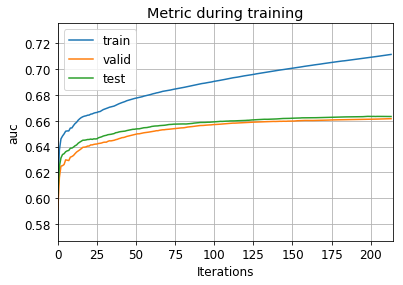

In [201]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

Plotting feature importances...


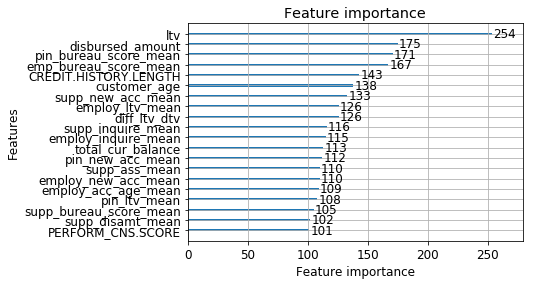

In [202]:
print('Plotting feature importances...')
ax = lgb.plot_importance(LGB_model, max_num_features=20)
plt.show()

In [165]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(solver='lbfgs',verbose=1)
LR_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=1, warm_start=False)

Scores for Random Forest model

Valid Threshold Cutoff: [0.231]

Test Threshold Cutoff: [0.234]

Valid AUC : 0.629
Test AUC : 0.629

Valid Accuracy: 0.599

Confusion Matrix for validation set

Predicted  False   True  __all__
Actual                          
False      10572   7030    17602
True        2321   3392     5713
__all__    12893  10422    23315

Test Accuracy: 0.595

Confusion Matrix for Test set

Predicted  False   True  __all__
Actual                          
False      10171   6833    17004
True        2617   3695     6312
__all__    12788  10528    23316

Valid Recall Score: 0.594
Test Recall Score: 0.585

Valid Precision Score: 0.325
Test Precision Score: 0.351

Valid F1 Score: 0.42
Test F1 Score: 0.439


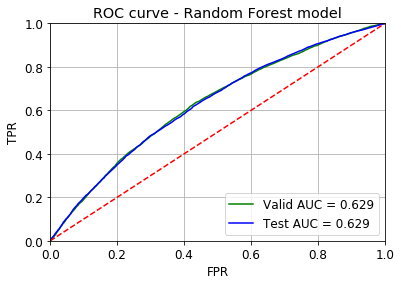

In [211]:
print_scores('Random Forest', RF_model)

Scores for XGboost model

Valid Threshold Cutoff: [0.21452638506889343]

Test Threshold Cutoff: [0.2177617847919464]

Valid AUC : 0.659
Test AUC : 0.661

Valid Accuracy: 0.613

Confusion Matrix for validation set

Predicted  False   True  __all__
Actual                          
False      10786   6816    17602
True        2213   3500     5713
__all__    12999  10316    23315

Test Accuracy: 0.618

Confusion Matrix for Test set

Predicted  False   True  __all__
Actual                          
False      10506   6498    17004
True        2413   3899     6312
__all__    12919  10397    23316

Valid Recall Score: 0.613
Test Recall Score: 0.618

Valid Precision Score: 0.339
Test Precision Score: 0.375

Valid F1 Score: 0.437
Test F1 Score: 0.467


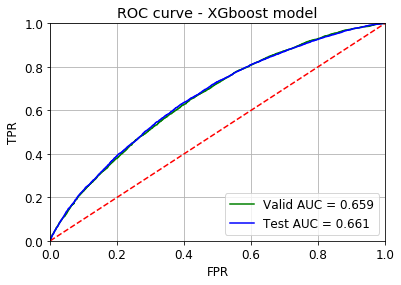

In [166]:
print_scores('XGboost',XGB_model)

Scores for Catboost model

Valid Threshold Cutoff: [0.17267397045876834]

Test Threshold Cutoff: [0.17505627942579663]

Valid AUC : 0.705
Test AUC : 0.709

Valid Accuracy: 0.644

Confusion Matrix for validation set

Predicted  False  True  __all__
Actual                         
False      11331  6271    17602
True        2036  3677     5713
__all__    13367  9948    23315

Test Accuracy: 0.652

Confusion Matrix for Test set

Predicted  False   True  __all__
Actual                          
False      11094   5910    17004
True        2194   4118     6312
__all__    13288  10028    23316

Valid Recall Score: 0.644
Test Recall Score: 0.652

Valid Precision Score: 0.37
Test Precision Score: 0.411

Valid F1 Score: 0.47
Test F1 Score: 0.504


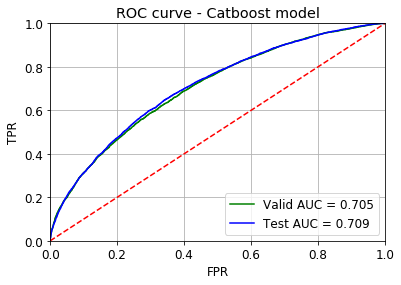

In [235]:
print_scores('Catboost', CB_model_full)

Scores for Light GBM model

Valid Threshold Cutoff: [0.21401891508413573]

Test Threshold Cutoff: [0.21716086387384995]

Valid AUC : 0.661
Test AUC : 0.663

Valid Accuracy: 0.614

Confusion Matrix for validation set

Predicted  False   True  __all__
Actual                          
False      10807   6795    17602
True        2207   3506     5713
__all__    13014  10301    23315

Test Accuracy: 0.621

Confusion Matrix for Test set

Predicted  False   True  __all__
Actual                          
False      10553   6451    17004
True        2396   3916     6312
__all__    12949  10367    23316

Valid Recall Score: 0.614
Test Recall Score: 0.62

Valid Precision Score: 0.34
Test Precision Score: 0.378

Valid F1 Score: 0.438
Test F1 Score: 0.47


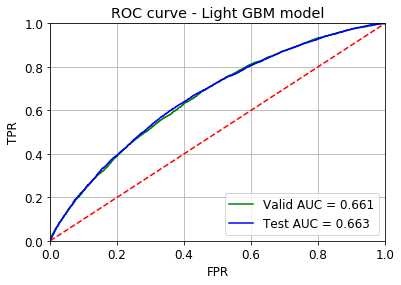

In [203]:
print_scores('Light GBM',LGB_model)

Scores for Logistic Regression model

Valid Threshold Cutoff: [0.21902782140678478]

Test Threshold Cutoff: [0.22139679950248037]

Valid AUC : 0.636
Test AUC : 0.636

Valid Accuracy: 0.599

Confusion Matrix for validation set

Predicted  False   True  __all__
Actual                          
False      10540   7062    17602
True        2295   3418     5713
__all__    12835  10480    23315

Test Accuracy: 0.597

Confusion Matrix for Test set

Predicted  False   True  __all__
Actual                          
False      10143   6861    17004
True        2547   3765     6312
__all__    12690  10626    23316

Valid Recall Score: 0.598
Test Recall Score: 0.596

Valid Precision Score: 0.326
Test Precision Score: 0.354

Valid F1 Score: 0.422
Test F1 Score: 0.445


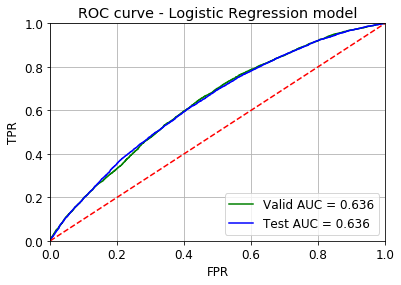

In [169]:
print_scores('Logistic Regression',LR_model)

In [267]:
test_df[num_cols] = scaler.fit_transform(test_df[num_cols])

In [268]:
display_all(test_df.head())

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Employment.Type,State_ID,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,customer_age,Employment.Type_NA,diff_ltv_dtv,high_loan_flag,Bureau_categories,id_score,brnch_bureau_score_mean,supp_bureau_score_mean,manuf_bureau_score_mean,pin_bureau_score_mean,state_bureau_score_mean,emp_bureau_score_mean,emptype_bureau_score_mean,id_bureau_score_mean,brnch_delinq_mean,supp_delinq_mean,manuf_delinq_mean,pin_delinq_mean,employ_delinq_mean,id_delinq_mean,bc_delinq_mean,supp_new_acc_mean,pin_new_acc_mean,employ_new_acc_mean,bc_new_acc_mean,brnch_inquire_mean,supp_inquire_mean,manuf_inquire_mean,pin_inquire_mean,employ_inquire_mean,brnch_acc_age_mean,supp_acc_age_mean,pin_acc_age_mean,employ_acc_age_mean,brnch_ltv_mean,supp_ltv_mean,manuf_ltv_mean,pin_ltv_mean,employ_ltv_mean,emptype_ltv_mean,brnch_disamt_mean,supp_disamt_mean,manuf_disamt_mean,pin_disamt_mean,state_disamt_mean,employ_disamt_mean,bc_disamt_mean,brnch_ass_mean,supp_ass_mean,pin_ass_mean,employ_ass_mean,total_accounts,total_act_accounts,total_cur_balance,total_emi,paid_percent,instalment_ratio,overdue_ratio,active_ratio,success_ratio,instalment_flag,avg_disbursed_amt,more_disbursed_flag,same_sanctioned_flag,sanc_amt_diff,avg_instalment,more_instalment_flag,young_risk_cust
233154,655269,-0.190835,-0.984765,1.035355,67,45,Salaried,6,-0.765147,-0.411825,-0.265934,-0.671531,-0.599485,-0.349935,1.023422,False,0.317868,0.0,No History,-0.493006,0.625459,1.019712,-0.880547,0.627940,0.722201,0.632566,0.837588,-0.413269,-0.416792,-0.531365,-0.988863,1.183222,-0.436854,-0.132861,-0.562128,-0.080409,0.084980,-0.200123,-0.934599,0.531797,1.767785,0.715192,0.819671,1.654079,-0.50797,1.397430,1.338050,0.953434,0.446542,1.670997,0.371944,0.717541,1.563348,1.128330,-0.581841,-0.047801,-0.868748,-0.159466,-0.926933,-0.110602,-0.580480,-0.861617,-0.731762,-0.610070,-0.860593,-0.648131,-0.565935,-0.434047,-0.538756,0.003414,-0.01475,-0.279813,-0.633838,-0.647914,-0.043779,-0.374426,0.370129,True,-0.017927,-0.330902,-0.384257,False
233155,723482,-0.010394,-1.017924,1.305065,67,45,Self employed,6,1.442619,0.962742,-0.265934,-0.020415,-0.120582,1.295666,-0.085439,False,0.066586,0.0,Very Low Risk,-0.493006,0.625459,1.019712,-0.880547,0.627940,0.722201,0.632566,-0.435359,-0.413269,-0.416792,-0.531365,-0.988863,1.183222,-0.436854,-0.132861,-0.290352,-0.080409,0.084980,-0.200123,0.941533,0.531797,1.767785,0.715192,0.819671,1.654079,-0.50797,1.397430,1.338050,0.953434,0.446542,1.670997,0.371944,0.717541,1.563348,-0.844475,-0.581841,-0.047801,-0.868748,-0.159466,-0.926933,-0.110602,-0.582593,-0.861617,-0.731762,-0.610070,-0.860593,0.043810,0.045878,-0.118468,1.144716,0.003504,-0.01152,-0.279813,0.794073,0.789376,-0.043779,-0.004497,0.370129,True,-0.017927,-0.014430,-0.384257,False
233156,758529,0.855813,0.758128,0.422716,78,86,Salaried,4,-0.765147,-0.411825,-0.265934,-0.671531,-0.599485,-0.349935,-1.194300,False,0.350774,0.0,No History,1.962020,-0.931088,-0.007366,0.782517,0.014187,0.446691,-1.110551,0.837588,1.573553,-0.677518,-0.520874,0.322027,-0.788513,-0.755045,0.341771,-0.562128,-0.331772,-0.118836,-0.690007,-0.934599,-0.545745,0.068347,0.004011,0.077309,-0.564785,-0.65339,0.395639,-0.524084,-0.853460,-0.101035,0.005233,0.658666,0.539733,0.701899,1.128330,-0.338795,0.558210,0.053340,0.404240,1.013824,-0.977058,-0.580480,-0.066801,0.337951,0.152149,-1.029103,-0.648131,-0.565935,-0.434047,-0.538756,0.003414,-0.01475,-0.279813,-0.633838,-0.647914,-0.043779,-0.374426,0.370129,True,-0.017927,-0.330902,-0.384257,True
233157,763449,-0.773657,-0.956391,0.112226,78,45,Self employed,4,-0.765147,-0.411825,-0.265934,1.688767,0.557864,-0.349935,1.023422,False,0.548210,0.0,Not Scored,-0.493006,-0.931088,-1.260067,-0.880547,-0.650337,0.446691,-1.110551,-0.435359,-0.413269,-0.677518,-0.726739,-0.988863,-1.098933,-0.755045,-0.132861,-0.354831,-1.041478,-0.71

In [270]:
test_df[cat_columns] = test_df[cat_columns].astype('str')

In [271]:
test_df[num_cols] = test_df[num_cols].fillna(test_df[num_cols].median())

In [272]:
final_test = test_df.drop('UniqueID', axis=1)

In [187]:
# final_test, _, nas = proc_df(df = test_df
#                              ,skip_flds=['UniqueID']
#                              ,na_dict=nas
#                             )

In [188]:
# extra_cols = ['supp_bureau_score_mean_na',
#  'manuf_bureau_score_mean_na',
#  'pin_bureau_score_mean_na',
#  'emp_bureau_score_mean_na',
#  'supp_delinq_mean_na',
#  'manuf_delinq_mean_na',
#  'pin_delinq_mean_na',
#  'employ_delinq_mean_na',
#  'supp_new_acc_mean_na',
#  'pin_new_acc_mean_na',
#  'employ_new_acc_mean_na',
#  'supp_inquire_mean_na',
#  'manuf_inquire_mean_na',
#  'pin_inquire_mean_na',
#  'employ_inquire_mean_na',
#  'supp_acc_age_mean_na',
#  'pin_acc_age_mean_na',
#  'employ_acc_age_mean_na',
#  'supp_ltv_mean_na',
#  'manuf_ltv_mean_na',
#  'pin_ltv_mean_na',
#  'employ_ltv_mean_na',
#  'supp_disamt_mean_na',
#  'manuf_disamt_mean_na',
#  'pin_disamt_mean_na',
#  'employ_disamt_mean_na',
#  'supp_ass_mean_na',
#  'pin_ass_mean_na',
#  'employ_ass_mean_na']

In [190]:
# final_test.drop(extra_cols, axis=1, inplace=True)

In [273]:
final_test.shape, cv_X.shape

((112392, 81), (233154, 81))

In [93]:
# final_test.to_csv(f'{PATH}final_test.csv', index=False)

In [280]:
# display_all(final_test.dtypes)

In [276]:
submission = pd.DataFrame()
submission['UniqueID'] = test_df['UniqueID']
submission['loan_default'] = CB_model_full.predict_proba(final_test)[:,1]
submission.shape

(112392, 2)

In [277]:
submission.head()

,UniqueID,loan_default
233154,655269,0.274851
233155,723482,0.354607
233156,758529,0.299243
233157,763449,0.278416
233158,708663,0.327759


In [278]:
submission['loan_default'].sum(), submission['loan_default'].mean()

(24642.249728954048, 0.21925270240723646)

In [279]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
submission.to_csv(f'{PATH}Submission_{file_timestamp}.csv', index=False)